# Lab 3: Obtención y Análisis de un Conjunto de Datos


## Students

Esteban Alfaro C4A072

Cesar Coronado C4A073

David Martinez B34019

## DataSet Acquisition

First, we started by selecting a Data Set. For this, we selected one that was meant to bse used with Regression and Clasification models, that is, low complexity models, based on the Kaggle search parameters. We chose a dataset that follows a similar structure to the one used in HomeWork 2. In Homework 2, we used Airbnb data. Here, we use apartment rental data for continental US listings. This facilitates cleaning tasks by being able to repurpose some of the concepts used previously. The data used is the following:

https://www.kaggle.com/datasets/shashanks1202/apartment-rent-data/data

The data already has the primary slots, like price and square footage, clean and ready to be analyzed, so the remaining tasks focus on smaller aspects of the data cleaning process. The descriptioned mentioned some non linear elements, which will be further analyzed in this collab.


## Data Cleaning

First we start by importing the libraries needed.

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

Now we import the file and understand its makeup with info, describe and head.

In [ ]:
# Read the CSV file
df = pd.read_csv('apartments_for_rent_classified_100K.csv', encoding='cp1252', delimiter=';', low_memory=False)

# Print NANs per column
print("NANs per column:")
print(df.isna().sum())
print("\n")

# Print 30 value head
print("First 30 rows:")
print(df.head(30))
print("\n")

# Print info
print("DataFrame Info:")
print(df.info())
print("\n")

# Print describe
print("DataFrame Description:")
print(df.describe())


NANs per column:
id                   0
category             0
title                0
body                 0
amenities        16044
bathrooms           63
bedrooms           124
currency             0
fee                  0
has_photo            0
pets_allowed     60424
price                1
price_display        1
price_type           0
square_feet          0
address          91549
cityname           302
state              302
latitude            25
longitude           25
source               0
time                 0
dtype: int64


First 30 rows:
            id                category  \
0   5668640009  housing/rent/apartment   
1   5668639818  housing/rent/apartment   
2   5668639686  housing/rent/apartment   
3   5668639659  housing/rent/apartment   
4   5668639374  housing/rent/apartment   
5   5668639368  housing/rent/apartment   
6   5668638765  housing/rent/apartment   
7   5668638578  housing/rent/apartment   
8   5668638476  housing/rent/apartment   
9   5668638122  housing/ren

AS can be seen from the NANs and the had, the 3 columns with the most NAN are amenities, pets allowed and address. Amenities and address are very specific to each apartment listing, and thus can't be filled in with predictions. AS such,  we remove these columns

In [ ]:
# Drop the columns and verify NANs once again
columns_to_drop = ['amenities', 'pets_allowed', 'address']
df = df.drop(columns=columns_to_drop)

print("NANs per column:")
print(df.isna().sum())
print("\n")

NANs per column:
id                 0
category           0
title              0
body               0
bathrooms         63
bedrooms         124
currency           0
fee                0
has_photo          0
price              1
price_display      1
price_type         0
square_feet        0
cityname         302
state            302
latitude          25
longitude         25
source             0
time               0
dtype: int64




As can be seen, the remaining characteristicas are less than 1%, so the remaining cleaning is fairly lax. First, we start by inferring bathrooms and bedrroms based on the square footage, because every row has square footage.

In [ ]:
# Round Bathrooms to nearest 0.5
def round_bathrooms(x):
    return np.ceil(x * 2) / 2

# Determine which are NANs
bathrooms_nan = df['bathrooms'].isna()
bedrooms_nan = df['bedrooms'].isna()

# Get the total amount of nans
bathrooms_nan_count = bathrooms_nan.sum()
bedrooms_nan_count = bedrooms_nan.sum()


# Loop to iterate through all NANs
for index, row in df[bathrooms_nan | bedrooms_nan].iterrows():
    # Get a +-300 square feet range.
    sqft = row['square_feet']
    similar_listings = df[(df['square_feet'] >= sqft - 300) & (df['square_feet'] <= sqft + 300)]
    ## Fill in the NANs with averages from properties +-300 SQFT
    if pd.isna(row['bathrooms']):
        avg_bathrooms = similar_listings['bathrooms'].mean()
        df.at[index, 'bathrooms'] = round_bathrooms(avg_bathrooms)

    if pd.isna(row['bedrooms']):
        avg_bedrooms = similar_listings['bedrooms'].mean()
        df.at[index, 'bedrooms'] = round(avg_bedrooms)

## Get the filled amount for statistics
bathrooms_filled = bathrooms_nan_count - df['bathrooms'].isna().sum()
bedrooms_filled = bedrooms_nan_count - df['bedrooms'].isna().sum()

print(f"Filled {bathrooms_filled} NaN values in 'bathrooms' column")
print(f"Filled {bedrooms_filled} NaN values in 'bedrooms' column")

Filled 60 NaN values in 'bathrooms' column
Filled 124 NaN values in 'bedrooms' column


We once again check the NANs and drop duplicates.

In [ ]:
## Remove duplicates with pandas function
duplicates_count = df.duplicated().sum()
df = df.drop_duplicates()
# Count how many where removed
remaining_nans = df.isna().sum().sum()
print(f"Dropped {duplicates_count} duplicate rows")

print("NANs per column:")
print(df.isna().sum())
print("\n")

Dropped 84 duplicate rows
NANs per column:
id                 0
category           0
title              0
body               0
bathrooms          3
bedrooms           0
currency           0
fee                0
has_photo          0
price              1
price_display      1
price_type         0
square_feet        0
cityname         302
state            302
latitude          25
longitude         25
source             0
time               0
dtype: int64




As the remaining values represent a very small amount of data based on the dataset, we can remove them. These columns are also categorical and much harder to fill.

In [ ]:
# Drop the remaining NANs
df = df.dropna()

print(f"Dropped {remaining_nans} rows with remaining NaN values")
print("\nFinal NANs per column:")
print(df.isna().sum())

# Reset Index
df.reset_index(drop=True, inplace=True)

Dropped 659 rows with remaining NaN values

Final NANs per column:
id               0
category         0
title            0
body             0
bathrooms        0
bedrooms         0
currency         0
fee              0
has_photo        0
price            0
price_display    0
price_type       0
square_feet      0
cityname         0
state            0
latitude         0
longitude        0
source           0
time             0
dtype: int64


As can be seen, the dataset is clean from empty spaces. We can now purge the outliers. For this, we look at the describe function from earlier earlier.

In [ ]:
# Print describe
print("DataFrame Description:")
print(df.describe())

DataFrame Description:
                 id     bathrooms      bedrooms         price   square_feet  \
count  9.910300e+04  99103.000000  99103.000000  99103.000000  99103.000000   
mean   5.358109e+09      1.445516      1.727647   1525.192476    955.500721   
std    1.846965e+08      0.547022      0.749092    899.230325    365.976176   
min    5.121046e+09      1.000000      0.000000    100.000000    101.000000   
25%    5.197948e+09      1.000000      1.000000   1012.000000    729.000000   
50%    5.508672e+09      1.000000      2.000000   1350.000000    900.000000   
75%    5.509006e+09      2.000000      2.000000   1795.000000   1115.000000   
max    5.669439e+09      9.000000      9.000000  52500.000000  12000.000000   

           latitude     longitude          time  
count  99103.000000  99103.000000  9.910300e+04  
mean      36.941299    -91.555459  1.559652e+09  
std        4.604581     15.832374  1.105018e+07  
min       19.573800   -159.369800  1.544174e+09  
25%       33.74

As can be seen, most numeric columns dont have hugh max and mins when compared to the mean, with the exception of price and square feet. So our outlier removal will focus on these 2. For this, will remove every price and squarefeet that is above our 99th percentile.

In [ ]:
# Get the 99th percentile for both
price_99_percentile = np.percentile(df['price'], 99)
sqft_99_percentile = np.percentile(df['square_feet'], 99)

print("\n99th Percentile Values:")
print(f"Price: ${price_99_percentile:.2f}")
print(f"Square Feet: {sqft_99_percentile:.2f}")

# Based on this 99th pecentile, we remove all values that go above it.

rows_before = len(df)
df = df[(df['square_feet'] <= 2259) & (df['price'] <= 4250)]
rows_after = len(df)
# Reset Index
df.reset_index(drop=True, inplace=True)

# Print the removed values
print(f"\nRemoved {rows_before - rows_after} rows where square_feet > 2259 or price > 4250")
print(f"Final DataFrame shape: {df.shape}")


99th Percentile Values:
Price: $4250.00
Square Feet: 2259.00

Removed 1761 rows where square_feet > 2259 or price > 4250
Final DataFrame shape: (97342, 19)


Now we have the final dataframe with 97342 columns. Now, we must define the columns that will be used for training. We use the .head function above to see that the numerical columns and also the categorical ones can fit our description. We first identify that columns category, title, body, currency, price_display, source and time aren't relevant, as the category is the same for every entry, body is a description belonging to the specific aparment which is unique for each listing, making it only useful for natural language or sentiment analysis. Title is also not a categoric class and only serves for language processing. Price display is the same as price but repeated with a dollar sign and currency is USD for every entry so it doesn't help an analysis, therefore, we drop them.

In [ ]:
columns_to_drop = ['category', 'title', 'body', 'currency', 'price_display', 'source','time']
df = df.drop(columns=columns_to_drop)

We check our remaining columns and values.

In [ ]:
print(df.head(30))

            id  bathrooms  bedrooms fee  has_photo   price price_type  \
0   5668640009        1.0       1.0  No  Thumbnail  2195.0    Monthly   
1   5668639818        1.5       3.0  No  Thumbnail  1250.0    Monthly   
2   5668639686        2.0       3.0  No  Thumbnail  1395.0    Monthly   
3   5668639659        1.0       2.0  No  Thumbnail  1600.0    Monthly   
4   5668639374        1.0       1.0  No  Thumbnail   975.0    Monthly   
5   5668639368        1.5       2.0  No  Thumbnail  1250.0    Monthly   
6   5668638765        2.0       2.0  No  Thumbnail  1600.0    Monthly   
7   5668638578        2.0       2.0  No  Thumbnail  1300.0    Monthly   
8   5668638476        1.0       2.0  No  Thumbnail   795.0    Monthly   
9   5668638122        2.0       2.0  No  Thumbnail  2150.0    Monthly   
10  5668638015        2.5       3.0  No  Thumbnail  1795.0    Monthly   
11  5668637809        2.0       2.0  No  Thumbnail  2395.0    Monthly   
12  5668637528        1.0       3.0  No  Thumbnail 

We know focus out attention to the 3 columns that appear to have mostly a single value. We count how many values they have and print them.

In [ ]:
# Print value counts for the specified columns
columns_of_interest = ['fee', 'has_photo', 'price_type']

for column in columns_of_interest:
    print(f"\nValue counts for {column}:")
    print(df[column].value_counts())


Value counts for fee:
fee
No     97152
Yes      190
Name: count, dtype: int64

Value counts for has_photo:
has_photo
Yes          54806
Thumbnail    33570
No            8966
Name: count, dtype: int64

Value counts for price_type:
price_type
Monthly           97340
Weekly                1
Monthly|Weekly        1
Name: count, dtype: int64


AS can be seen, the fee column has almost no values in Yes, which means the Yes value wouldn't be useful in a regression analysis. With Price_type, we see that it has 3 classes, but only 1 value out of more than 97 000 for 2 of the 3 classes, so we can remove it. Finally, has_photo appears to have 3 classes with a lot of

We now have to transform the 3 remaining using one hot encoding and Target encoding.

In [ ]:
columns_to_drop = ['fee', 'price_type']
df = df.drop(columns=columns_to_drop)

In [ ]:
# Perform one-hot encoding
df_encoded = pd.get_dummies(df, columns=['has_photo'], prefix='photo')

# Display the first few rows of the encoded DataFrame
print(df_encoded.head())


           id  bathrooms  bedrooms   price  square_feet       cityname state  \
0  5668640009        1.0       1.0  2195.0          542  Redondo Beach    CA   
1  5668639818        1.5       3.0  1250.0         1500   Newport News    VA   
2  5668639686        2.0       3.0  1395.0         1650        Raleigh    NC   
3  5668639659        1.0       2.0  1600.0          820      Vacaville    CA   
4  5668639374        1.0       1.0   975.0          624    Albuquerque    NM   

   latitude  longitude  photo_No  photo_Thumbnail  photo_Yes  
0   33.8520  -118.3759     False             True      False  
1   37.0867   -76.4941     False             True      False  
2   35.8230   -78.6438     False             True      False  
3   38.3622  -121.9712     False             True      False  
4   35.1038  -106.6110     False             True      False  


In [ ]:
!pip install category_encoders
from category_encoders import TargetEncoder

# Create a TargetEncoder
encoder = TargetEncoder(cols=['cityname', 'state'])

# Fit and transform the encoder on the original dataframe
encoded_columns = encoder.fit_transform(df[['cityname', 'state']], df['price'])

# Rename the columns to be representative
encoded_columns.columns = ['cityname_encoded', 'state_encoded']

# Add the encoded columns to df_encoded
df_encoded = pd.concat([df_encoded, encoded_columns], axis=1)

# Display the first few rows of the encoded DataFrame
print(df_encoded.head())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 4.0 MB/s eta 0:00:00
           id  bathrooms  bedrooms   price  square_feet       cityname state  \
0  5668640009        1.0       1.0  2195.0          542  Redondo Beach    CA   
1  5668639818        1.5       3.0  1250.0         1500   Newport News    VA   
2  5668639686        2.0       3.0  1395.0         1650        Raleigh    NC   
3  5668639659        1.0       2.0  1600.0          820      Vacaville    CA   
4  5668639374        1.0       1.0   975.0          624    Albuquerque    NM   

   latitude  longitude  photo_No  photo_Thumbnail  photo_Yes  \
0   33.8520  -118.3759     False             True      False   
1   37.0867   -76.4941     False             True      False   
2   35.8230   -78.6438     False             True      False   
3   38.3622  -121.9712     False             True      False   
4   35.1038  -106.6110     False             True      False   

   cityname_encoded  state_encoded  
0       2547.956803

In [ ]:
# Now remove the original columns
columns_to_drop = ['cityname', 'state']
df_encoded = df_encoded.drop(columns=columns_to_drop)
# Display the first few rows of the encoded DataFrame
print(df_encoded.head())

           id  bathrooms  bedrooms   price  square_feet  latitude  longitude  \
0  5668640009        1.0       1.0  2195.0          542   33.8520  -118.3759   
1  5668639818        1.5       3.0  1250.0         1500   37.0867   -76.4941   
2  5668639686        2.0       3.0  1395.0         1650   35.8230   -78.6438   
3  5668639659        1.0       2.0  1600.0          820   38.3622  -121.9712   
4  5668639374        1.0       1.0   975.0          624   35.1038  -106.6110   

   photo_No  photo_Thumbnail  photo_Yes  cityname_encoded  state_encoded  
0     False             True      False       2547.956803    2211.773813  
1     False             True      False       1079.133484    1480.738671  
2     False             True      False       1242.160880    1145.729327  
3     False             True      False       1849.724384    2211.773813  
4     False             True      False       1306.431543    1095.470077  


Now, we calculate the Gain Ratio, Correlation and F value, which are used for feasture selection in regression.

In [ ]:

from sklearn.feature_selection import mutual_info_regression, f_regression
from scipy.stats import entropy

# Define function for the gain ratio calculation, idea gotten from https://github.com/maha-prathamesh/Feature-Selection-Techniques/blob/main/Feature%20Selection%20Based%20on%20Mutual%20Information%20(Entropy)%20Gain.ipynb
def calculate_gain_ratio(X, y):
    mi = mutual_info_regression(X, y)
    # Use the entropy and the mutual info regression to get the gain ratio.
    feature_entropy = np.array([calculate_entropy(X[col]) for col in X.columns])
    gain_ratio = mi / feature_entropy
    return gain_ratio
# Entropy calculator, https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html
def calculate_entropy(column):
    _, counts = np.unique(column, return_counts=True)
    probabilities = counts / len(column)
    return -np.sum(probabilities * np.log2(probabilities + 1e-10))
# Correlation function, https://numpy.org/devdocs/reference/generated/numpy.corrcoef.html
def calculate_correlation(X, y):
    return np.array([abs(np.corrcoef(X[col], y)[0, 1]) for col in X.columns])



# Now create the features and target
X = df_encoded[['square_feet','bathrooms','bedrooms', 'latitude', 'longitude', 'photo_No', 'photo_Thumbnail', 'photo_Yes', 'cityname_encoded', 'state_encoded']]
y = df_encoded['price']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate Gain Ratio
gain_ratio = calculate_gain_ratio(X_train, y_train)

# Calculate Correlation
correlation = calculate_correlation(X_train, y_train)

# Calculate F-value
f_values, _ = f_regression(X_train, y_train)



# Create a DataFrame with the results
results = pd.DataFrame({
    'Feature': X.columns,
    'Gain Ratio': gain_ratio,
    'Correlation': correlation,
    'F-value': f_values
})

# Sort the results by Correlation, as that value is more important for regression problems.
results_sorted = results.sort_values('Correlation', ascending=False)

print(results_sorted)

            Feature  Gain Ratio  Correlation       F-value
8  cityname_encoded    0.082004     0.729515  88588.150818
9     state_encoded    0.089899     0.612226  46686.772780
0       square_feet    0.043805     0.325454   9225.251732
1         bathrooms    0.060032     0.271655   6204.474879
2          bedrooms    0.038328     0.188929   2882.421336
3          latitude    0.058497     0.110358    960.078987
4         longitude    0.067130     0.090115    637.551065
6   photo_Thumbnail    0.008520     0.076738    461.272005
7         photo_Yes    0.004411     0.050954    202.705040
5          photo_No    0.010255     0.038655    116.527880


As we can see, the correlation and F value both indicate that the top 5 features are cityname_encoded, state_encoded, square_feet, bathrooms and bedrooms. It also indicates that square feet, bathrooms and bedrooms are heavily non linear when compared to the target encoded columns, which means that models that handle non linear relationships will likely do better in the future sections.

 These 5 are the ones we will use. First, we use a standar scaler to the numeric values and then saved these scaled values. The standard scaler was used as it deals with the excesive variance of price and price derived columns.

In [ ]:
df = df_encoded.copy()
scaler = StandardScaler()
df[['square_feet', 'latitude', 'longitude', 'cityname_encoded',  'state_encoded']] = scaler.fit_transform(df[['square_feet', 'latitude', 'longitude', 'cityname_encoded',  'state_encoded']])
# Save clean DF for future use.
df.to_csv('clean_apartments_for_rent.csv', index=False)

## Training and Model Applications

We start now by taking the clean and scaled dataset and appying models to it. The 80-20 division was used before and will be used in each model as well. We selected 4 models focused on regression: Polynomial, Ridge, Elastic Net and Random Forest. For all these, the MAE, MSE, RMSE and RMSPE were calculated to give meaningful performance metrics. All these models were trained with the exact same columns and data to ensure that all other variables aside from model remain consistent.

### Polynomial Regression

Now, we move on to implementing a polynomial regression. For this, we tried to do it with sklearn, but the toll it took on the hardware past grade 5 made it unviable, as it took several hours just for grade 6. So, we instead switched to Pytorch for this model alone and used CUDA to speed up the process consdierably.

Polynomial regression is  is a form of regression analysis where the relationship between the independent variables and the dependent variable is modeled via a polynomial of the nth degree, where N is the discrete value of the poly grade. It's an continuation of linear regression that allows for more complex, non-linear relationships to be captured, like the ones seen in the feature selection for this data set. It can be used to model curved relationships and better fit non  linear data points. It uses the following formula Polynomial: y = b*0 + b1*x + b2*x^2....bn*x^n and is generally more prone to overfitting, so a hyper parameter analysis is required. [2]

Using device: cuda

Polynomial Grade 1:
MAE-TEST: 274.36
MAE-TRAINING: 269.88
MSE-TEST: 140039.53
MSE-TRAINING: 138145.09
RMSE-TEST: 374.22
RMSE-TRAINING: 371.68
RMSPE-TEST: 27.97%
RMSPE-TRAINING: 27.94%

Polynomial Grade 2:
MAE-TEST: 258.74
MAE-TRAINING: 255.10
MSE-TEST: 128335.20
MSE-TRAINING: 127285.99
RMSE-TEST: 358.24
RMSE-TRAINING: 356.77
RMSPE-TEST: 26.20%
RMSPE-TRAINING: 26.26%

Polynomial Grade 3:
MAE-TEST: 251.49
MAE-TRAINING: 247.77
MSE-TEST: 121241.87
MSE-TRAINING: 120076.25
RMSE-TEST: 348.20
RMSE-TRAINING: 346.52
RMSPE-TEST: 25.30%
RMSPE-TRAINING: 25.28%

Polynomial Grade 4:
MAE-TEST: 249.44
MAE-TRAINING: 245.84
MSE-TEST: 119781.74
MSE-TRAINING: 117926.48
RMSE-TEST: 346.10
RMSE-TRAINING: 343.40
RMSPE-TEST: 25.24%
RMSPE-TRAINING: 25.16%

Polynomial Grade 5:
MAE-TEST: 248.87
MAE-TRAINING: 244.75
MSE-TEST: 119266.76
MSE-TRAINING: 116860.95
RMSE-TEST: 345.35
RMSE-TRAINING: 341.85
RMSPE-TEST: 25.11%
RMSPE-TRAINING: 25.00%

Polynomial Grade 6:
MAE-TEST: 250.93
MAE-TRAINING: 246.

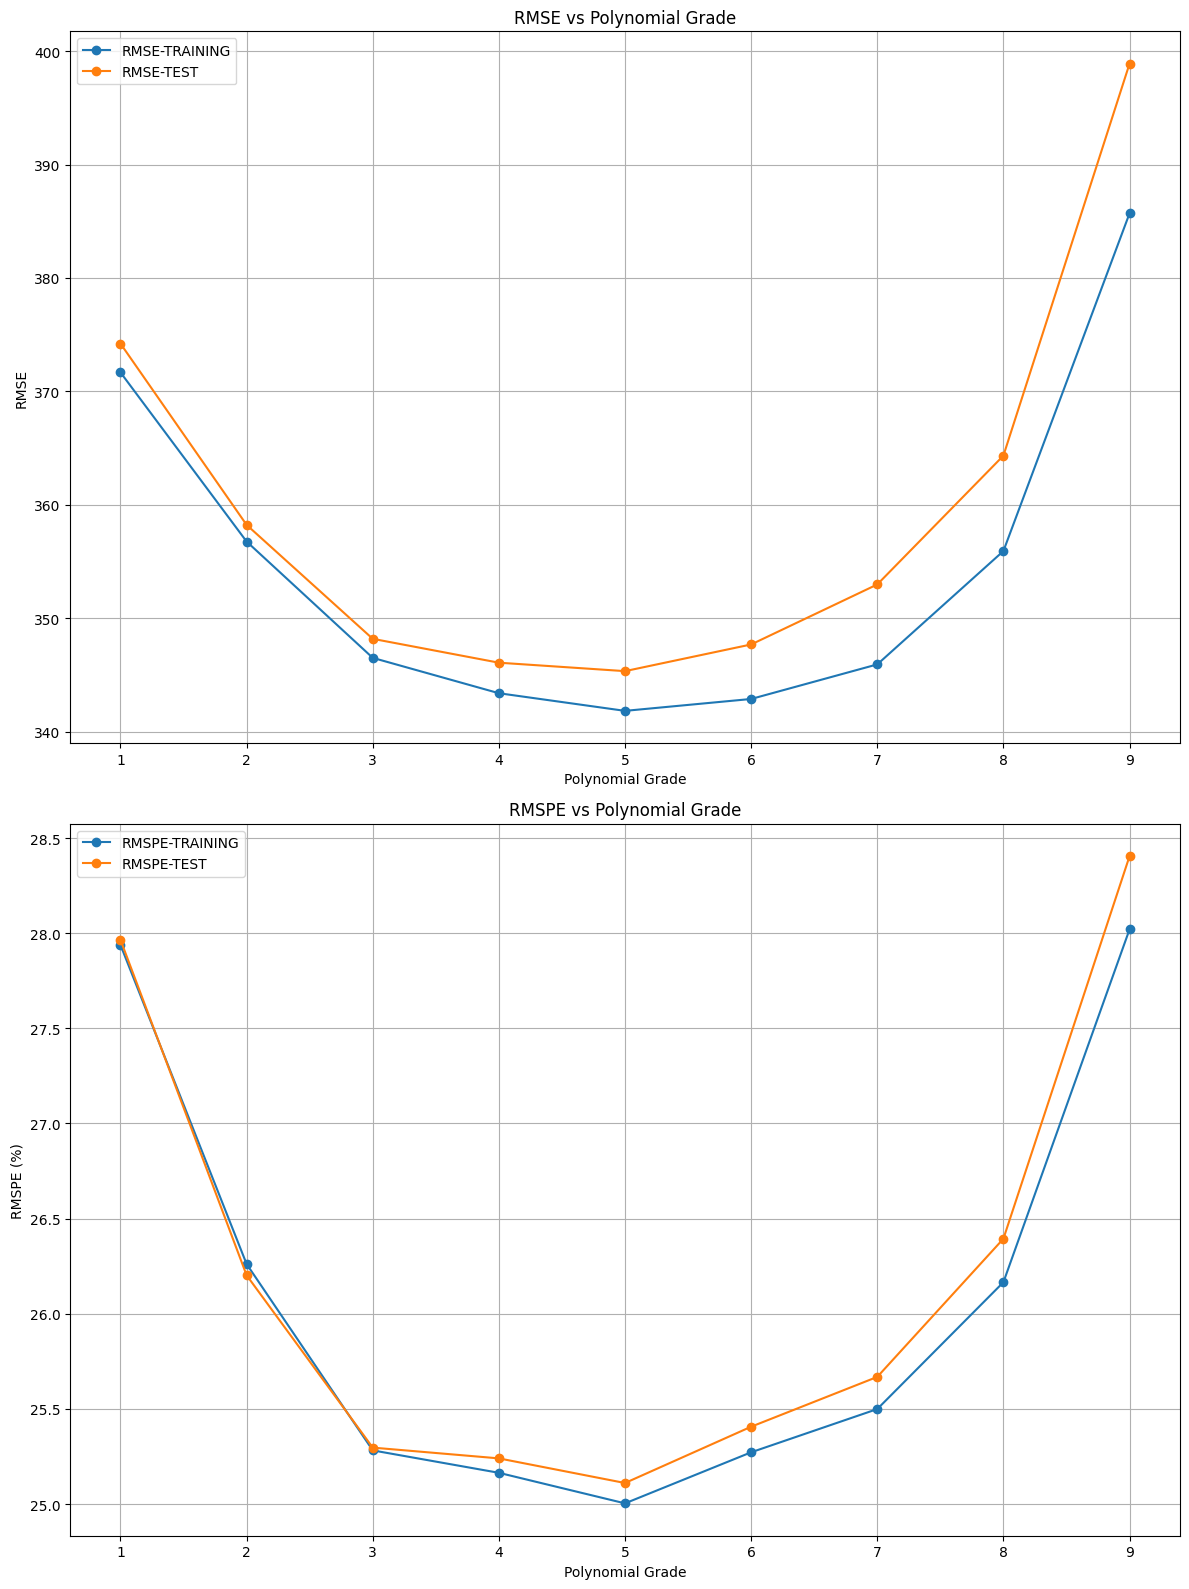

In [ ]:

##################################################################
######################Training###################################
#################################################################
# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Prepare the features and target based on feature analysis.
X = df[['bedrooms', 'bathrooms', 'square_feet', 'cityname_encoded',  'state_encoded']]
y = df['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to calculate metrics, based on their statistical definitions [4].
def calculate_metrics(y_true, y_pred):
    mae = torch.mean(torch.abs(y_true - y_pred)).item()
    mse = torch.mean((y_true - y_pred)**2).item()
    rmse = torch.sqrt(torch.mean((y_true - y_pred)**2)).item()
    rmspe = torch.sqrt(torch.mean(((y_true - y_pred) / y_true)**2)).item() * 100
    return mae, mse, rmse, rmspe

# Lists to store metric values for plotting
rmse_train_list, rmse_test_list = [], []
rmspe_train_list, rmspe_test_list = [], []

# Polynomial regression for degrees 1-9
for degree in range(1, 10):
    # Create polynomial features using scikit-learn and assigning all 9 variants for polynomials 1-9
    poly = PolynomialFeatures(degree, include_bias=False)
    # Fit the training variables unto polynomial features for training.
    X_poly_train = poly.fit_transform(X_train)
    X_poly_test = poly.transform(X_test)

    # Convert to PyTorch tensors and move to GPU to leverage CUDA for faster execution
    X_poly_train_tensor = torch.FloatTensor(X_poly_train).to(device)
    X_poly_test_tensor = torch.FloatTensor(X_poly_test).to(device)
    y_train_tensor = torch.FloatTensor(y_train.values).to(device)
    y_test_tensor = torch.FloatTensor(y_test.values).to(device)

    # Define model, loss function, and optimizer, to use in the trianing of the model.
    model = nn.Linear(X_poly_train.shape[1], 1).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.1)

    # Train the model, Epoch, or execution number, is defined based on several previous runs to balance execution time
    # instead of using grid search to find it.
    num_epochs = 15000
    for epoch in range(num_epochs):
      # Trian the model with the loss function and optimizer, code based on code gotten from https://stackoverflow.com/questions/75906819/simple-linear-regression-in-pytorch-why-loss-is-increasing-with-each-epoch
        optimizer.zero_grad()
        outputs = model(X_poly_train_tensor)
        loss = criterion(outputs.squeeze(), y_train_tensor)
        loss.backward()
        optimizer.step()

    # Make predictions
    with torch.no_grad():
        y_pred_train = model(X_poly_train_tensor).squeeze()
        y_pred_test = model(X_poly_test_tensor).squeeze()

    # Calculate metrics based on functions defined.
    mae_train, mse_train, rmse_train, rmspe_train = calculate_metrics(y_train_tensor, y_pred_train)
    mae_test, mse_test, rmse_test, rmspe_test = calculate_metrics(y_test_tensor, y_pred_test)
    # Append results to list for graphing
    rmse_train_list.append(rmse_train)
    rmse_test_list.append(rmse_test)
    rmspe_train_list.append(rmspe_train)
    rmspe_test_list.append(rmspe_test)
    # Print results
    print(f"\nPolynomial Grade {degree}:")
    print(f"MAE-TEST: {mae_test:.2f}")
    print(f"MAE-TRAINING: {mae_train:.2f}")
    print(f"MSE-TEST: {mse_test:.2f}")
    print(f"MSE-TRAINING: {mse_train:.2f}")
    print(f"RMSE-TEST: {rmse_test:.2f}")
    print(f"RMSE-TRAINING: {rmse_train:.2f}")
    print(f"RMSPE-TEST: {rmspe_test:.2f}%")
    print(f"RMSPE-TRAINING: {rmspe_train:.2f}%")

# Plotting definitions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))

# RMSE plot
ax1.plot(range(1, 10), rmse_train_list, label='RMSE-TRAINING', marker='o')
ax1.plot(range(1, 10), rmse_test_list, label='RMSE-TEST', marker='o')
ax1.set_xlabel('Polynomial Grade')
ax1.set_ylabel('RMSE')
ax1.set_title('RMSE vs Polynomial Grade')
ax1.legend()
ax1.set_xticks(range(1, 10))
ax1.grid(True)

# RMSPE plot
ax2.plot(range(1, 10), rmspe_train_list, label='RMSPE-TRAINING', marker='o')
ax2.plot(range(1, 10), rmspe_test_list, label='RMSPE-TEST', marker='o')
ax2.set_xlabel('Polynomial Grade')
ax2.set_ylabel('RMSPE (%)')
ax2.set_title('RMSPE vs Polynomial Grade')
ax2.legend()
ax2.set_xticks(range(1, 10))
ax2.grid(True)

plt.tight_layout()
plt.show()

As can be seen, the best grade that reduces test and training error was grade 5, with an error of about 25% for both test and training. The best statistics for this was a MAE of 250, MSE of 120000 and RMSE of 347,70. These results are fairly adequate, as they provide a 3/4 chance of getting an input value correct.



### Ridge

We now move on to using a lineal model in the form of Ridge regression, also known as L2 regression, as seen in class.


Alpha: 0.001
MAE-TEST: 264.23
MAE-TRAINING: 260.41
MSE-TEST: 132811.06
MSE-TRAINING: 131076.93
RMSE-TEST: 364.43
RMSE-TRAINING: 362.05
RMSPE-TEST: 27.33%
RMSPE-TRAINING: 27.43%

Alpha: 0.01
MAE-TEST: 264.23
MAE-TRAINING: 260.41
MSE-TEST: 132811.06
MSE-TRAINING: 131076.93
RMSE-TEST: 364.43
RMSE-TRAINING: 362.05
RMSPE-TEST: 27.33%
RMSPE-TRAINING: 27.43%

Alpha: 0.1
MAE-TEST: 264.23
MAE-TRAINING: 260.41
MSE-TEST: 132811.06
MSE-TRAINING: 131076.93
RMSE-TEST: 364.43
RMSE-TRAINING: 362.05
RMSPE-TEST: 27.33%
RMSPE-TRAINING: 27.43%

Alpha: 1
MAE-TEST: 264.23
MAE-TRAINING: 260.41
MSE-TEST: 132811.13
MSE-TRAINING: 131076.93
RMSE-TEST: 364.43
RMSE-TRAINING: 362.05
RMSPE-TEST: 27.33%
RMSPE-TRAINING: 27.43%

Alpha: 10
MAE-TEST: 264.23
MAE-TRAINING: 260.41
MSE-TEST: 132811.79
MSE-TRAINING: 131076.93
RMSE-TEST: 364.43
RMSE-TRAINING: 362.05
RMSPE-TEST: 27.33%
RMSPE-TRAINING: 27.43%

Alpha: 100
MAE-TEST: 264.23
MAE-TRAINING: 260.40
MSE-TEST: 132818.82
MSE-TRAINING: 131077.43
RMSE-TEST: 364.44
RMSE-TRA

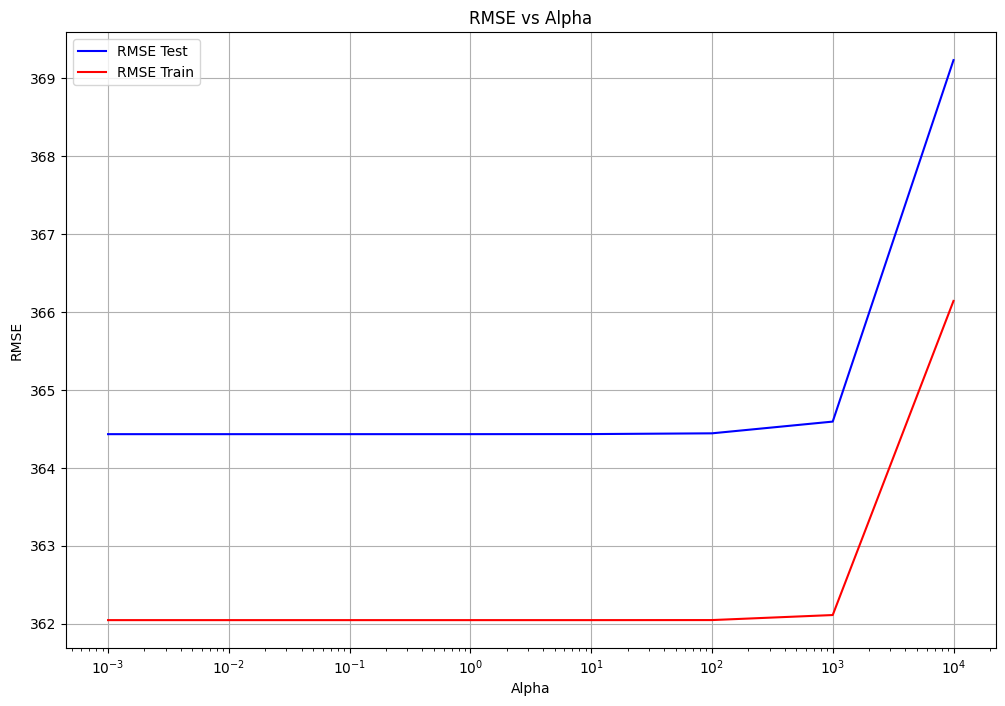

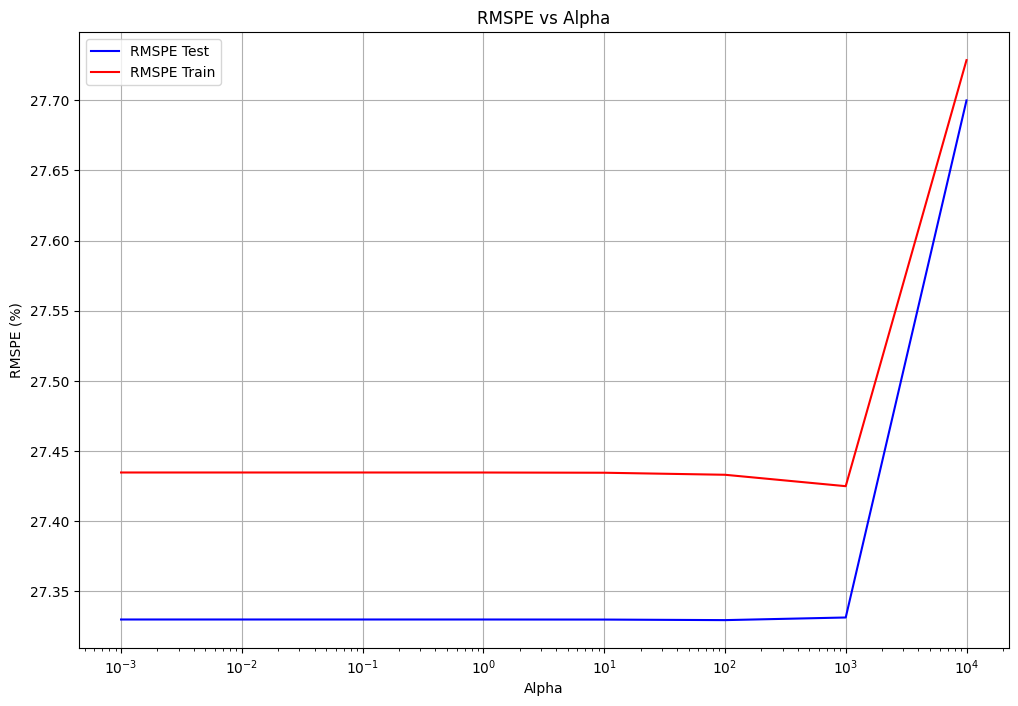


Best alpha: 0.001


In [ ]:

# Select features and target
X = df[['bedrooms', 'bathrooms', 'square_feet', 'cityname_encoded',  'state_encoded']]
y = df['price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features if they arent scaled already.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define alpha values to test
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

# Lists to store results
mae_test_list, mae_train_list = [], []
mse_test_list, mse_train_list = [], []
rmse_test_list, rmse_train_list = [], []
rmspe_test_list, rmspe_train_list = [], []

# Function to calculate RMSPE, as its not in sklearn
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))) * 100

# Train models and calculate metrics, the metrics are already defined, which differs from pytorch.
for alpha in alphas:
    # Train the model for ech alpha.
    model = Ridge(alpha=alpha)
    model.fit(X_train_scaled, y_train)
    # Make a prediction based on the fitted model for test and train
    y_pred_test = model.predict(X_test_scaled)
    y_pred_train = model.predict(X_train_scaled)
    # Get the metrics for all the values that were also used in polynomial
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_test = np.sqrt(mse_test)
    rmse_train = np.sqrt(mse_train)
    rmspe_test = rmspe(y_test, y_pred_test)
    rmspe_train = rmspe(y_train, y_pred_train)
    # Add the values to a list for graphing below.
    mae_test_list.append(mae_test)
    mae_train_list.append(mae_train)
    mse_test_list.append(mse_test)
    mse_train_list.append(mse_train)
    rmse_test_list.append(rmse_test)
    rmse_train_list.append(rmse_train)
    rmspe_test_list.append(rmspe_test)
    rmspe_train_list.append(rmspe_train)
    # Print the results for the metrics for each alpha
    print(f"\nAlpha: {alpha}")
    print(f"MAE-TEST: {mae_test:.2f}")
    print(f"MAE-TRAINING: {mae_train:.2f}")
    print(f"MSE-TEST: {mse_test:.2f}")
    print(f"MSE-TRAINING: {mse_train:.2f}")
    print(f"RMSE-TEST: {rmse_test:.2f}")
    print(f"RMSE-TRAINING: {rmse_train:.2f}")
    print(f"RMSPE-TEST: {rmspe_test:.2f}%")
    print(f"RMSPE-TRAINING: {rmspe_train:.2f}%")

# Plot alpha vs metrics for RMSE and RMSPE
plt.figure(figsize=(12, 8))
plt.semilogx(alphas, rmse_test_list, 'b-', label='RMSE Test')
plt.semilogx(alphas, rmse_train_list, 'r-', label='RMSE Train')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.title('RMSE vs Alpha')
plt.legend()
plt.grid(True)
plt.show()
# Plot alpha vs metrics for RMSE and RMSPE
plt.figure(figsize=(12, 8))
plt.semilogx(alphas, rmspe_test_list, 'b-', label='RMSPE Test')
plt.semilogx(alphas, rmspe_train_list, 'r-', label='RMSPE Train')
plt.xlabel('Alpha')
plt.ylabel('RMSPE (%)')
plt.title('RMSPE vs Alpha')
plt.legend()
plt.grid(True)
plt.show()



As can be seen, an alpha of 1000 gave us the best results of 27,3%. However, results didn't change that much between the 2.

### Elastic Net

We chose Elastic Net as it is a combination of two models we saw in class: lasso(L1) and ridge (L2). Elastic Net uses a combination of L1 and L2 penalties, controlled by two parameters: α, used as a constant to multipy the penalty terms and λ to set the equilibrium between the two penalties. This way, ElasticNet can select relevant variables as Lasso and handlemulticollinearity as Ridge [5][6].

We use GridSearchCV approach to find the best fitting hyper-parameters. This method and the following Random Forest method, require the variation of several hyper parameters for proper configuration. As such, we'll only calculate the result for the best hyper parameters it obtains with grid search, as a graph similar to the one done for Polynomial and Ridge wouldn't be possible, as it requires the use of further dimensions.

In [ ]:
# Select features and target
X = df[['bedrooms', 'bathrooms', 'square_feet', 'cityname_encoded',  'state_encoded']]
y = df['price']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# Define the model
elastic_net = ElasticNet()

# Define the hyperparameters and their possible values
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0.1, 0.5, 0.7, 0.9, 1.0]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=elastic_net, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error')

# Fit the model
grid_search.fit(X_train, y_train)

# Best hyperparameters and score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Best Hyperparameters: {'alpha': 0.01, 'l1_ratio': 1.0}
Best Score: -362.08560186018065


Let's now make predictions for both the trainig and test set.

In [ ]:
# Make predictions on the test set using the best model
y_test_pred = grid_search.best_estimator_.predict(X_test)
y_train_pred = grid_search.best_estimator_.predict(X_train)

Agregate Metrics of the result of the model

In [ ]:
# Calculate metrics
def calculate_metrics(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    mse = np.mean((y_true - y_pred)**2)
    rmse = np.sqrt(mse)
    rmspe = np.sqrt(np.mean(((y_true - y_pred) / y_true)**2)) * 100
    return mae, mse, rmse, rmspe

# Calculate metrics for test set
mae_test, mse_test, rmse_test, rmspe_test = calculate_metrics(y_test, y_test_pred)

# Calculate metrics for training set
mae_train, mse_train, rmse_train, rmspe_train = calculate_metrics(y_train, y_train_pred)

print(f"MAE-TEST: {mae_test:.2f}")
print(f"MAE-TRAINING: {mae_train:.2f}")
print(f"MSE-TEST: {mse_test:.2f}")
print(f"MSE-TRAINING: {mse_train:.2f}")
print(f"RMSE-TEST: {rmse_test:.2f}")
print(f"RMSE-TRAINING: {rmse_train:.2f}")
print(f"RMSPE-TEST: {rmspe_test:.2f}%")
print(f"RMSPE-TRAINING: {rmspe_train:.2f}%")

MAE-TEST: 264.23
MAE-TRAINING: 260.41
MSE-TEST: 132811.00
MSE-TRAINING: 131076.93
RMSE-TEST: 364.43
RMSE-TRAINING: 362.05
RMSPE-TEST: 27.33%
RMSPE-TRAINING: 27.43%


### Random Forest Regressor


Continue with the metods that were discuseed in the class, we decided to use a Random Forest regressor. This is implemented below:

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

# Define rf as Random Forest for regression
rf = RandomForestRegressor()

# Select features and target
X = df[['bedrooms', 'bathrooms', 'square_feet', 'cityname_encoded',  'state_encoded']]
y = df['price']


# Split the data into training and testing sets (based on 80/20 --> training/test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#For Grid Search with all the hyper parameters
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_features': ['sqrt', 'log2'],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True, False]
# }

# Best parameters selected from previous execution
param_grid = {
    'n_estimators': [300],
    'max_features': ['log2'],
    'max_depth': [20],
    'min_samples_split': [5],
    'min_samples_leaf': [1],
    'bootstrap': [True]
}


# Using Grid Search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters definition and print
best_grid = grid_search.best_estimator_
grid_predictions = best_grid.predict(X_test)
print(f"Grid Search Best Parameters: {grid_search.best_params_}")
print(f"Grid Search Mean Squared Error: {mean_squared_error(y_test, grid_predictions)}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Grid Search Best Parameters: {'bootstrap': True, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Grid Search Mean Squared Error: 76564.71457179413


After getting best model is time to make the predictions using the test/train set:

In [ ]:
# Predictions on the test/train set using the best model
y_test_pred = grid_search.best_estimator_.predict(X_test)
y_train_pred = grid_search.best_estimator_.predict(X_train)

Then, we just calculate the metrics to evaluate the model selected

In [ ]:
# Function to calculate metrics of the model
def calculate_metrics(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    mse = np.mean((y_true - y_pred)**2)
    rmse = np.sqrt(mse)
    rmspe = np.sqrt(np.mean(((y_true - y_pred) / y_true)**2)) * 100
    return mae, mse, rmse, rmspe

# Calculate metrics for test set
mae_test, mse_test, rmse_test, rmspe_test = calculate_metrics(y_test, y_test_pred)

# Calculate metrics for training set
mae_train, mse_train, rmse_train, rmspe_train = calculate_metrics(y_train, y_train_pred)

# Show the result of the metrics
print(f"MAE-TEST: {mae_test:.2f}")
print(f"MAE-TRAINING: {mae_train:.2f}")
print(f"MSE-TEST: {mse_test:.2f}")
print(f"MSE-TRAINING: {mse_train:.2f}")
print(f"RMSE-TEST: {rmse_test:.2f}")
print(f"RMSE-TRAINING: {rmse_train:.2f}")
print(f"RMSPE-TEST: {rmspe_test:.2f}%")
print(f"RMSPE-TRAINING: {rmspe_train:.2f}%")

MAE-TEST: 180.06
MAE-TRAINING: 126.91
MSE-TEST: 76564.71
MSE-TRAINING: 36317.42
RMSE-TEST: 276.70
RMSE-TRAINING: 190.57
RMSPE-TEST: 20.17%
RMSPE-TRAINING: 14.04%


### Bonus: XGboost

XGBoost (Extreme Gradient Boosting) is an machine learning algorithm user for regression and clasification. It works by applying the "boosting" technique, where multiple decision trees are trained sequencially. On each iteration, XGBoosts adjusts a new tree and tries to fix the errors in previous trees [1][7].


In [ ]:
import xgboost as xgb

X = df[['bedrooms', 'bathrooms', 'square_feet', 'cityname_encoded',  'state_encoded']]
y = df['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regressor=xgb.XGBRegressor(eval_metric='rmsle')

from sklearn.model_selection import GridSearchCV

# set up our search grid
param_grid = {"max_depth":    [4, 5, 6],
              "n_estimators": [500, 600, 700],
              "learning_rate": [0.01, 0.015]}

# try out every combination of the above values
search = GridSearchCV(regressor, param_grid, cv=5).fit(X_train, y_train)

print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'learning_rate': 0.015, 'max_depth': 6, 'n_estimators': 700}


In [ ]:
regressor=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],
                           eval_metric='rmsle')

regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmsle', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.015, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=700, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_test_pred = regressor.predict(X_test)
y_train_pred = regressor.predict(X_train)

In [ ]:
# Calculate metrics
def calculate_metrics(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    mse = np.mean((y_true - y_pred)**2)
    rmse = np.sqrt(mse)
    rmspe = np.sqrt(np.mean(((y_true - y_pred) / y_true)**2)) * 100
    return mae, mse, rmse, rmspe

# Calculate metrics for test set
mae_test, mse_test, rmse_test, rmspe_test = calculate_metrics(y_test, y_test_pred)

# Calculate metrics for training set
mae_train, mse_train, rmse_train, rmspe_train = calculate_metrics(y_train, y_train_pred)

print(f"MAE-TEST: {mae_test:.2f}")
print(f"MAE-TRAINING: {mae_train:.2f}")
print(f"MSE-TEST: {mse_test:.2f}")
print(f"MSE-TRAINING: {mse_train:.2f}")
print(f"RMSE-TEST: {rmse_test:.2f}")
print(f"RMSE-TRAINING: {rmse_train:.2f}")
print(f"RMSPE-TEST: {rmspe_test:.2f}%")
print(f"RMSPE-TRAINING: {rmspe_train:.2f}%")

MAE-TEST: 223.07
MAE-TRAINING: 215.12
MSE-TEST: 98095.17
MSE-TRAINING: 90866.46
RMSE-TEST: 313.20
RMSE-TRAINING: 301.44
RMSPE-TEST: 22.60%
RMSPE-TRAINING: 22.03%


## Result Analysis

In order to understand the differences each model can provide in terms of results, a table has bee compiled for all the metrics used and each model's result.

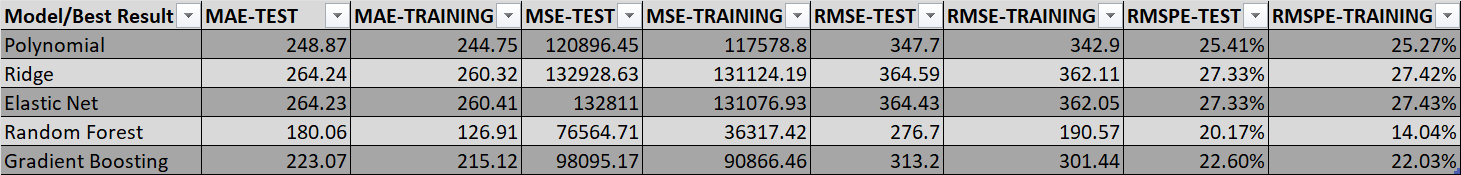

As can be seen in the previous table, the best result across the board was Random Forest. Then, gradient boosting, followed by polynomial and finally, Ridge and Elastic net produced almost identical results.

First, Random Forest being the first is intuitive upon first glance, as it has the highest number of hyper parameters to vary compared to Poly (1), ridge (1), Elastic Net (2) and Gradient Boosting (3). These were varied using grid search. By tuning a higher number of parameters, we can more finely adjust the results. Comparatively, however, this caused the greatest disparity between training and test, which means it's more overfitted than the other models. It's still the best model however, as it has the greatest accuracy in the TEST function, even considering the overfitting compared to its training set.

Due to its use of several randomly constructed trees and averaging out the result, as explained in the material for this course, Random Forest is more resilient to outliers and nonlinear data relationships, like the ones we outlined during feature selection. It also handles high dimensional data well, which explains why using 5 columns, and especially target encoded ones, wasn't an issue for training, especially when using columns like bedrooms and bathrooms that have a discrete nature and much more limited range when compared to price and target encoded City/State. It also handled the nonlinear nature of our data set better, as is a feature of tree based systems. [1]

In a similar fashion, Gradient boosting can also deal better with outliers and nonlinear data relationships. As explained before, the repetitive gradient descent, using weaker iterations each time, allows the model to be better tuned for data with more complex relationships and non-linearity. While the accuracy wasn't as good, it showed better generalization, as the difference between training and testing was smaller. [1]

The polynomial approach can capture a lot of the nonlinear features of this dataset, especially when it comes to square footage and the discrete values of bedrooms and bathrooms. However, it’s very sensitive to outliers and data discrepancies, which can explain why it couldn't adjust as well, especially because it doesn't have the corrective nature that comes along with using several regressions layered on top of each other like Random Forest and Gradient Boosting, which can fix these deficiencies. It also only has 1 hyper parameter that was varied, instead of the more complex nature of random forest with its depth, estimators and split parameters that come from tree-based systems, which can model complex feature interactions. To combat this, neural networks can be used in conjunction to this method, with the downside of adding complexity. [2]

Lastly, this data set has relations that are mostly nonlinear, like the discrete bedrooms and bathrooms and the volatile nature of square footage, which was reaffirmed in the feature selection portion by looking at correlation and F value. As such, it was to be expected that the linear models like Elastic Net (R1 and R2 combined) and Ridge (R2), which are linear models with regularized mechanisms, would fair the worst. It was also seen that the difference between L1 and L1+L2 is negligible. This means that the L1 penalty isn't providing much corrective properties. This is to be expected, as the feature selection was done in a previous step to the training, as outline in the exercise requirements. The R2 regression also didn't vary as much with the Alpha, which could also be explained by this previous feature selection. [3]




## Citations

[1] E. K. Sahin, "Assessing the predictive capability of ensemble tree methods for landslide susceptibility mapping using XGBoost, gradient boosting machine, and random forest," SN Applied Sciences, vol. 2, no. 7, p. 1308, Jun. 2020, doi: 10.1007/s42452-020-3060-1.

[2] P. Morala, J. A. Cifuentes, R. E. Lillo, and I. Ucar, "Towards a mathematical framework to inform neural network modelling via polynomial regression," Neural Networks, vol. 142, pp. 57-72, Oct. 2021, doi: 10.1016/j.neunet.2021.04.036.

[3] R. W. Hoerl, "Ridge Regression: A Historical Context," Technometrics, vol. 62, no. 4, pp. 420-425, 2020, doi: 10.1080/00401706.2020.1742207.

[4] T. Chai and R. R. Draxler, "Root mean square error (RMSE) or mean absolute error (MAE)? – Arguments against avoiding RMSE in the literature," Geosci. Model Dev., vol. 7, pp. 1247-1250, 2014, doi: 10.5194/gmd-7-1247-2014.

[5] “ElasticNet,” scikit-learn, 2024. https://scikit-learn.org/dev/modules/generated/sklearn.linear_model.ElasticNet.html# (accessed Oct. 22, 2024).

[6] CFI Team, “Elastic Net,” Corporate Finance Institute. https://corporatefinanceinstitute.com/resources/data-science/elastic-net/

[7[ xgboost developers, “XGBoost Documentation — xgboost 1.5.1 documentation,” xgboost.readthedocs.io, 2022. https://xgboost.readthedocs.io/en/stable/